In [33]:
# Import library yang kalian butuhkan
import os
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report
from skimage.feature import graycomatrix, graycoprops
from scipy.stats import entropy
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay)
import seaborn as sns
import pywt

## Data Loading

Buat struktur folder dataset sebagai berikut:
```
.
└──dataset
    ├── label1
	├── image1.jpg
	├── image2.jpg
	└── image3.jpg
    ├── label2
    └── label3
    └── dst...
```

In [34]:
data = []
labels = []
file_name = []

for sub_folder in os.listdir("dataset\\"):
    sub_folder_files = os.listdir(os.path.join("dataset\\", sub_folder))
    for i, filename in enumerate(sub_folder_files):
        img_path = os.path.join("dataset\\", sub_folder, filename)
        img = cv.imread(img_path)
        img = cv.resize(img, (224, 224))
        img = img.astype(np.uint8)
        img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        
        data.append(img)
        labels.append(sub_folder)
        name = os.path.splitext(filename)[0]
        file_name.append(filename)
        
data = np.array(data)
labels = np.array(labels)

## Data Augmentation

### Define Augmentation Function


In [35]:
# melakukan augmentasi data
data_augmented = []
labels_augmented = []
paths_augmented = []
file_name_augmented = []
angles = [0, 45, 90, 135]

for i in range(len(data)):
    img = data[i]
    label = labels[i]
    name = file_name[i]
    
    (h, w) = img.shape[:2]
    center = (w // 2, h // 2)
    
    for angle in angles:
        M = cv.getRotationMatrix2D(center, angle, 1.0)
        rotated = cv.warpAffine(img, M, (w, h))
        
        data_augmented.append(rotated)
        labels_augmented.append(label)
        # Tambah keterangan rotasi ke nama file
        file_name_augmented.append(f"{os.path.splitext(name)[0]}_rot{angle}.jpg")

data_augmented = np.array(data_augmented)
labels_augmented = np.array(labels_augmented)

In [36]:
print("Data sebelum augmentasi: ", len(data))
print("Data setelah augmentasi: ", len(data_augmented))

Data sebelum augmentasi:  200
Data setelah augmentasi:  800


## Data Preparation

### Define Preprocessing Function


In [37]:
def prepro1(img):
    img_eq = cv.equalizeHist(img)

    kernel = np.array([[0, -1, 0],
                       [-1, 5, -1],
                       [0, -1, 0]])
    sharp_img = cv.filter2D(img_eq, -1, kernel)
    return sharp_img

def prepro2(img):
    img_eq = cv.equalizeHist(img)

    kernel = np.array([[0, -1, 0],
                       [-1, 5, -1],
                       [0, -1, 0]])
    sharp_img = cv.filter2D(img_eq, -1, kernel)

    median_img = cv.medianBlur(sharp_img, 3)
    img_blur = cv.GaussianBlur(median_img, (3,3), 0)
    return img_blur

def prepro3(img):
    img_eq = cv.equalizeHist(img)

    kernel = np.array([[0, -1, 0],
                       [-1, 5, -1],
                       [0, -1, 0]])
    sharp_img = cv.filter2D(img_eq, -1, kernel)

    median_img = cv.medianBlur(sharp_img, 3)
    img_blur = cv.GaussianBlur(median_img, (3,3), 0)
    return img_blur

### Preprocessing

In [38]:
# pada bagian ini bisa gunakan data yang sebelum augmentasi atau setelah augmentasi
dataPreprocessed = []
for i in range(len(data)): # Loop through each image and do preprocessing
	img = data[i]
    # coba pakai salah satu prepro, misal prepro1
	img_proc = prepro1(img)
	dataPreprocessed.append(img_proc)

### Feature Extraction

In [39]:
def glcm(image, derajat):
    if derajat == 0:
        angles = [0]
    elif derajat == 45:
        angles = [np.pi / 4]
    elif derajat == 90:
        angles = [np.pi / 2]
    elif derajat == 135:
        angles = [3 * np.pi / 4]
    else:
        raise ValueError("Invalid angle. It should be one of the following: 0, 45, 90, 135.")
    
    # mengembalikan matrix glcm dari image
    glcm = graycomatrix(image, [1], angles, 256, symmetric=True, normed=True)
    return glcm

In [40]:
def correlation(matriks):
	return graycoprops(matriks, 'correlation')[0, 0]

In [41]:
def dissimilarity(matriks):
    return graycoprops(matriks, 'dissimilarity')[0, 0]

In [42]:
def homogenity(matriks):
    return graycoprops(matriks, 'homogeneity')[0, 0]

In [43]:
def contrast(matriks):
    return graycoprops(matriks, 'contrast')[0, 0]

In [44]:
def ASM(matriks):
    return graycoprops(matriks, 'ASM')[0, 0]

In [45]:
def energy(matriks):
    return graycoprops(matriks, 'energy')[0, 0]

In [46]:
def entropyGlcm(matriks):
    return entropy(matriks.ravel())

In [47]:
Derajat0 = []
Derajat45 = []
Derajat90 = []
Derajat135 = []
for i in range(len(dataPreprocessed)):
    D0 = glcm(dataPreprocessed[i], 0)
    D45 = glcm(dataPreprocessed[i], 45)
    D90 = glcm(dataPreprocessed[i], 90)
    D135 = glcm(dataPreprocessed[i], 135)
    Derajat0.append(D0)
    Derajat45.append(D45)
    Derajat90.append(D90)
    Derajat135.append(D135)

In [48]:
Kontras0, Kontras45, Kontras90, Kontras135 = [], [], [], []
dissimilarity0, dissimilarity45, dissimilarity90, dissimilarity135 =  [], [], [], []
homogenity0, homogenity45, homogenity90, homogenity135 = [], [], [], []
entropy0, entropy45, entropy90, entropy135 =  [], [], [], []
ASM0, ASM45, ASM90, ASM135 =  [], [], [], []
energy0, energy45, energy90, energy135 =  [], [], [], []
correlation0, correlation45, correlation90, correlation135 = [], [], [], []


In [49]:
for i in range(len(dataPreprocessed)):
    C0 = correlation(Derajat0[i])
    correlation0.append(C0)
    C45 = correlation(Derajat45[i])
    correlation45.append(C45)
    C90 = correlation(Derajat90[i])
    correlation90.append(C90)
    C135 = correlation(Derajat135[i])
    correlation135.append(C135)

In [50]:
for i in range(len(data)):
    K0 = contrast(Derajat0[i])
    K45 = contrast(Derajat45[i])
    K90 = contrast(Derajat90[i])
    K135 = contrast(Derajat135[i])
    Kontras0.append(K0)
    Kontras45.append(K45)
    Kontras90.append(K90)
    Kontras135.append(K135)

In [51]:
for i in range(len(data)):
    Dis0 = dissimilarity(Derajat0[i])
    Dis45 = dissimilarity(Derajat45[i])
    Dis90 = dissimilarity(Derajat90[i])
    Dis135 = dissimilarity(Derajat135[i])
    dissimilarity0.append(Dis0)
    dissimilarity45.append(Dis45)
    dissimilarity90.append(Dis90)
    dissimilarity135.append(Dis135)

In [52]:
for i in range(len(data)):
    H0 = homogenity(Derajat0[i])
    H45 = homogenity(Derajat45[i])
    H90 = homogenity(Derajat90[i])
    H135 = homogenity(Derajat135[i])
    homogenity0.append(H0)
    homogenity45.append(H45)
    homogenity90.append(H90)
    homogenity135.append(H135)

In [53]:
for i in range(len(data)):  
    E0 = entropyGlcm(Derajat0[i])
    E45 = entropyGlcm(Derajat45[i])
    E90 = entropyGlcm(Derajat90[i])
    E135 = entropyGlcm(Derajat135[i])
    entropy0.append(E0)
    entropy45.append(E45)
    entropy90.append(E90)
    entropy135.append(E135)

In [54]:
for i in range(len(data)):
    A0 = ASM(Derajat0[i])
    A45 = ASM(Derajat45[i])
    A90 = ASM(Derajat90[i])
    A135 = ASM(Derajat135[i])
    ASM0.append(A0)
    ASM45.append(A45)
    ASM90.append(A90)
    ASM135.append(A135)

In [55]:
for i in range(len(data)):
    ER0 = energy(Derajat0[i])
    ER45 = energy(Derajat45[i])
    ER90 = energy(Derajat90[i])
    ER135 = energy(Derajat135[i])
    energy0.append(ER0)
    energy45.append(ER45)
    energy90.append(ER90)
    energy135.append(ER135)

### Write the extraction's results to CSV 

In [56]:
dataTable = {'Filename': file_name, 'Label': labels,
        'Contrast0': Kontras0, 'Contrast45': Kontras45, 'Contrast90': Kontras90, 'Contrast135': Kontras135,
        'Homogeneity0': homogenity0, 'Homogeneity45': homogenity45, 'Homogeneity90': homogenity90, 'Homogeneity135': homogenity135,
        'Dissimilarity0': dissimilarity0, 'Dissimilarity45': dissimilarity45, 'Dissimilarity90': dissimilarity90, 'Dissimilarity135': dissimilarity135,
        'Entropy0': entropy0, 'Entropy45': entropy45, 'Entropy90': entropy90, 'Entropy135': entropy135,
        'ASM0': ASM0, 'ASM45': ASM45, 'ASM90': ASM90, 'ASM135': ASM135,
        'Energy0': energy0, 'Energy45': energy45, 'Energy90': energy90, 'Energy135': energy135,
        'Correlation0': correlation0, 'Correlation45': correlation45, 'Correlation90': correlation90, 'Correlation135': correlation135,
        }
df = pd.DataFrame(dataTable)
df.to_csv('hasil_ekstraksi_1.csv', index=False)

hasilEkstrak = pd.read_csv('hasil_ekstraksi_1.csv')
hasilEkstrak


,Filename,Label,Contrast0,Contrast45,Contrast90,Contrast135,Homogeneity0,Homogeneity45,Homogeneity90,Homogeneity135,...,ASM90,ASM135,Energy0,Energy45,Energy90,Energy135,Correlation0,Correlation45,Correlation90,Correlation135
0,1163.png,withMask,67.385010,95.455268,60.542981,102.357578,0.211112,0.178533,0.214487,0.173149,...,0.000261,0.000214,0.015897,0.014697,0.016142,0.014617,0.993887,0.991324,0.994506,0.990696
1,1174.png,withMask,314.104040,554.471636,356.159573,542.985522,0.187353,0.154650,0.185320,0.153149,...,0.000290,0.000234,0.017922,0.015733,0.017018,0.015304,0.973139,0.952655,0.969678,0.953636
2,1175.png,withMask,879.344351,1031.199582,317.879304,1068.959983,0.143040,0.116696,0.173255,0.115260,...,0.001345,0.000498,0.024231,0.022526,0.036675,0.022326,0.926837,0.914049,0.973575,0.910902
3,1203.png,withMask,223.845892,452.772789,257.164017,410.563695,0.154254,0.113573,0.144635,0.115242,...,0.000232,0.000162,0.015734,0.012362,0.015223,0.012713,0.980570,0.960677,0.977723,0.964342
4,1361.png,withMask,55.918302,91.318607,73.709381,90.531541,0.229127,0.191224,0.214337,0.188831,...,0.000269,0.000233,0.017146,0.015381,0.016404,0.015271,0.994961,0.991765,0.993348,0.991836
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,967.png,withoutMask,142.715707,291.512819,209.967849,297.755535,0.216194,0.194488,0.237930,0.188949,...,0.004663,0.004036,0.064796,0.063916,0.068286,0.063527,0.988592,0.976696,0.983239,0.976197
196,972.png,withoutMask,372.509950,616.263669,329.767917,637.508094,0.136766,0.108867,0.142811,0.107751,...,0.000405,0.000206,0.017733,0.014625,0.020120,0.014366,0.968876,0.948478,0.972465,0.946703
197,973.png,withoutMask,281.121276,467.197269,265.107503,421.847433,0.146686,0.119612,0.147766,0.119506,...,0.000355,0.000246,0.018149,0.015810,0.018849,0.015669,0.976003,0.960078,0.977361,0.963954
198,998.png,withoutMask,761.820047,1160.769109,706.391196,1216.333668,0.146487,0.125287,0.163064,0.120549,...,0.000827,0.000474,0.026576,0.022238,0.028765,0.021762,0.939224,0.907447,0.943653,0.903016


### Features Selection

pada bagian seleksi fitur ini bisa menggunakan metode seperti
- PCA
- LDA
- t-SNE
- Chi-square
- ANOVA
- Autoencoder
- correlation
- dll

berikut contoh menggunakan correlation:

<Axes: >

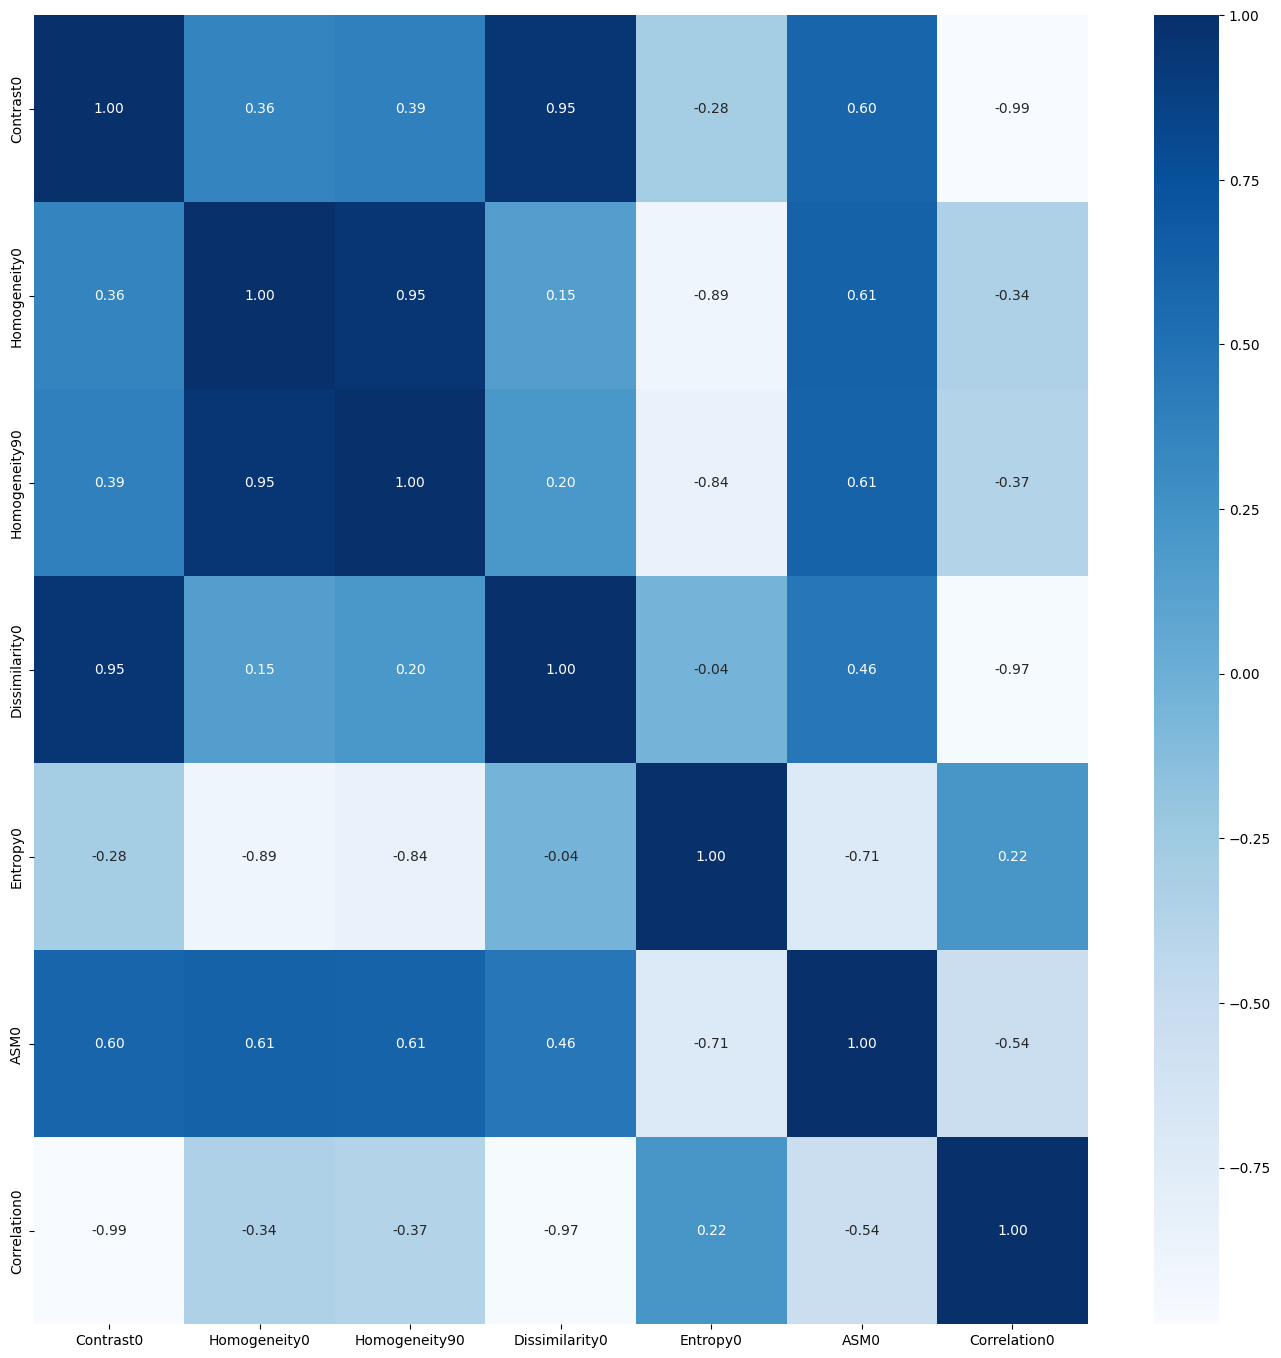

In [57]:
# Menghitung korelasi
correlation = hasilEkstrak.drop(columns=['Label','Filename']).corr()

# Menyaring fitur yang memiliki korelasi absolut lebih dari 0.95 dengan label
threshold = 0.95 # atur threshold ini untuk menentukan seberapa besar korelasi yang ingin disaring
selectionFeature = []
columns = np.full((correlation.shape[0],), True, dtype=bool)
for i in range(correlation.shape[0]):
	for j in range(i+1, correlation.shape[0]):
		if correlation.iloc[i,j] >= threshold:
			if columns[j]:
				columns[j] = False
select = hasilEkstrak.drop(columns=['Label','Filename']).columns[columns]
x_new = hasilEkstrak[select]
x_new
y = hasilEkstrak['Label']
plt.figure(figsize=(17,17))
sns.heatmap(x_new.corr(), annot=True, cmap='Blues', fmt=".2f")

## Splitting Data

In [58]:
# ubah bagian test_size sesuai kebutuhan
# 0.3 = 30% data untuk testing (train/test 70/30)
# 0.2 = 20% data untuk testing (train/test 80/20)
X_train, X_test, y_train, y_test = train_test_split(x_new, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)

(160, 7)
(40, 7)


## Feature Normalization

berikut metode normalisasi yang bisa digunakan:
- Min-Max Scaling
- Standardization (Z-score)
- Robust Scaling
- MaxAbsScaler
- dll

berikut contoh menggunakan Standardization (Z-score):

In [59]:
# normalisasi mean std
X_test = (X_test - X_train.mean()) / X_train.std()
X_train = (X_train - X_train.mean()) / X_train.std()

## Modeling

### Define Model

In [60]:
def generateClassificationReport(y_true, y_pred):
	print(classification_report(y_true, y_pred))
	print(confusion_matrix(y_true, y_pred))
	print('Accuracy:', accuracy_score(y_true, y_pred))

# Define classifiers
rf = RandomForestClassifier(n_estimators=5, random_state=42)
svm = SVC(kernel='rbf', random_state=42)
knn = KNeighborsClassifier(n_neighbors=5)

### Train Random Forest Classifier

In [61]:
# Train Random Forest Classifier
rf.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("------Training Set------")
y_pred = rf.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = rf.predict(X_test)
generateClassificationReport( y_test, y_pred)

------Training Set------
              precision    recall  f1-score   support

    withMask       0.98      1.00      0.99        79
 withoutMask       1.00      0.98      0.99        81

    accuracy                           0.99       160
   macro avg       0.99      0.99      0.99       160
weighted avg       0.99      0.99      0.99       160

[[79  0]
 [ 2 79]]
Accuracy: 0.9875

------Testing Set------
              precision    recall  f1-score   support

    withMask       0.79      0.90      0.84        21
 withoutMask       0.88      0.74      0.80        19

    accuracy                           0.82        40
   macro avg       0.83      0.82      0.82        40
weighted avg       0.83      0.82      0.82        40

[[19  2]
 [ 5 14]]
Accuracy: 0.825


### Train SVM Classifier

In [62]:
# Train SVM Classifier
svm.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred = svm.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = svm.predict(X_test)
generateClassificationReport( y_test, y_pred)


------Training Set------
              precision    recall  f1-score   support

    withMask       0.90      0.76      0.82        79
 withoutMask       0.80      0.91      0.85        81

    accuracy                           0.84       160
   macro avg       0.85      0.84      0.84       160
weighted avg       0.84      0.84      0.84       160

[[60 19]
 [ 7 74]]
Accuracy: 0.8375

------Testing Set------
              precision    recall  f1-score   support

    withMask       0.86      0.86      0.86        21
 withoutMask       0.84      0.84      0.84        19

    accuracy                           0.85        40
   macro avg       0.85      0.85      0.85        40
weighted avg       0.85      0.85      0.85        40

[[18  3]
 [ 3 16]]
Accuracy: 0.85


### Train KNN Classifier

In [63]:
# Train KNN Classifier
knn.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred = knn.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = knn.predict(X_test)
generateClassificationReport( y_test, y_pred)



------Training Set------
              precision    recall  f1-score   support

    withMask       0.91      0.80      0.85        79
 withoutMask       0.82      0.93      0.87        81

    accuracy                           0.86       160
   macro avg       0.87      0.86      0.86       160
weighted avg       0.87      0.86      0.86       160

[[63 16]
 [ 6 75]]
Accuracy: 0.8625

------Testing Set------
              precision    recall  f1-score   support

    withMask       0.86      0.90      0.88        21
 withoutMask       0.89      0.84      0.86        19

    accuracy                           0.88        40
   macro avg       0.88      0.87      0.87        40
weighted avg       0.88      0.88      0.87        40

[[19  2]
 [ 3 16]]
Accuracy: 0.875


## Evaluation With Confusion Matrix

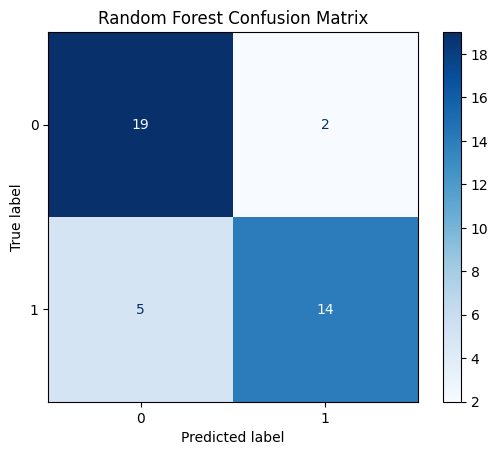

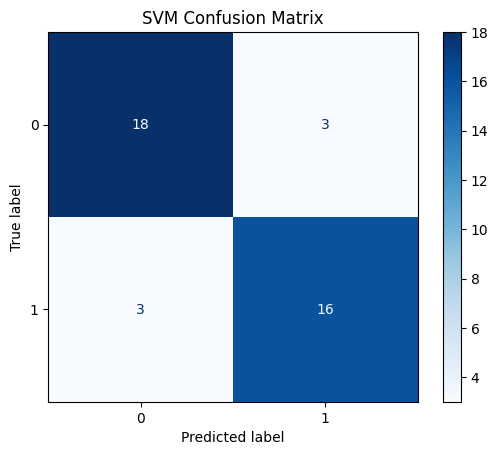

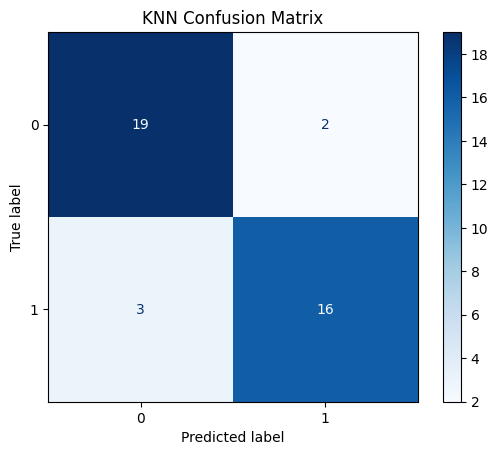

In [64]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()

# Plot confusion matrix for Random Forest
plot_confusion_matrix(y_test, rf.predict(X_test), "Random Forest Confusion Matrix")
# Plot confusion matrix for SVM
plot_confusion_matrix(y_test, svm.predict(X_test), "SVM Confusion Matrix")
# Plot confusion matrix for KNN
plot_confusion_matrix(y_test, knn.predict(X_test), "KNN Confusion Matrix")